# Testings and benchmarkings for univariate scan functions

We will be using the BXD data for testing purposes. In this notebook, we are testing the univariate scan functionalities, by performing the functions on the 108th BXD trait. 

## Preparation:

In [1]:
pwd()

"/Users/zifanyu/Documents/GitHub/BulkLMM.jl/test/notebooks"

In [2]:
cd("..")

In [3]:
using Test
using Plots

In [4]:
include("BXDdata_for_test.jl"); ## Load BXD data used for testing:

In [5]:
include("../src/parallel_helpers.jl");

In [6]:
include("testHelper.jl");

In [7]:
kinship_Gc = readdlm("run-gemma/output/kinship.cXX.txt", '\t');

In [8]:
pheno_y = reshape(pheno[:, 108], :, 1);
(y0, X0, lambda0) = transform_rotation(pheno_y, geno, kinship_Gc); # by default will add an intercept to geno
X0_intercept = reshape(X0[:, 1], :, 1);
X0_covar = X0[:, 2:end];

In [9]:
BLAS.set_num_threads(Threads.nthreads())

## Test simple scans:

In [10]:
@time test_alt = scan(pheno_y, geno, kinship_Gc; reml = false, assumption = "alt", method = "qr");

  2.070167 seconds (5.79 M allocations: 2.600 GiB, 21.97% gc time)


In [11]:
lods_alt = test_alt[4];

In [12]:
findall(lods_alt .< 0) # confirm that uncorrected solution contains invalid LOD scores

241-element Vector{Int64}:
  229
  230
  231
  232
  233
  234
  235
  236
  237
  238
  239
  240
  241
    ⋮
 6112
 6113
 6114
 6115
 6116
 6117
 6118
 6119
 6123
 6124
 7227
 7228

perform correction by taking $(var(y_{108}), 0.1)$

In [13]:
var(pheno_y)

1.6944289276209026

In [14]:
prior = [var(pheno_y), 1/10]

2-element Vector{Float64}:
 1.6944289276209026
 0.1

In [15]:
@time test_alt_corrected = scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "alt", method = "qr");

  0.946355 seconds (2.64 M allocations: 1.181 GiB, 22.31% gc time, 1.88% compilation time)


In [16]:
lods_alt_corrected = test_alt_corrected[4];

In [17]:
findall(lods_alt_corrected .< 0)

Int64[]

In [18]:
hcat(lods_alt, lods_alt_corrected)

7321×2 Matrix{Float64}:
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.021912   0.0199922
 0.0567256  0.0417663
 ⋮          
 0.248678   0.263758
 0.248678   0.263758
 0.248678   0.263758
 0.0686881  0.122407
 0.124881   0.136544
 0.124881   0.136544
 0.249213   0.255818
 0.273645   0.288192
 0.271594   0.285219
 0.285893   0.309153
 0.229505   0.219606
 0.229505   0.219606

In [19]:
@benchmark scan(pheno_y, geno, kinship_Gc; reml = false, assumption = "alt", method = "qr")

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.662 s …  1.681 s  ┊ GC (min … max): 10.90% … 11.96%
 Time  (median):     1.675 s             ┊ GC (median):    11.85%
 Time  (mean ± σ):   1.673 s ± 9.944 ms  ┊ GC (mean ± σ):  11.57% ±  0.58%

  █                                      █               █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.66 s        Histogram: frequency by time        1.68 s <

 Memory estimate: 2.60 GiB, allocs estimate: 5791909.

In [20]:
@benchmark scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "alt", method = "qr")

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  774.105 ms … 859.950 ms  ┊ GC (min … max): 12.43% … 13.54%
 Time  (median):     807.606 ms               ┊ GC (median):    12.55%
 Time  (mean ± σ):   811.039 ms ±  28.624 ms  ┊ GC (mean ± σ):  12.64% ±  0.93%

  ▁        ▁       ▁     ▁            █                       ▁  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  774 ms           Histogram: frequency by time          860 ms <

 Memory estimate: 1.18 GiB, allocs estimate: 2625680.

In [21]:
@benchmark scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "alt", method = "cholesky")

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  575.934 ms … 630.765 ms  ┊ GC (min … max): 14.25% … 15.82%
 Time  (median):     608.377 ms               ┊ GC (median):    15.89%
 Time  (mean ± σ):   604.567 ms ±  18.676 ms  ┊ GC (mean ± σ):  15.08% ±  1.23%

  █  █            █                 █ █      ██  █            █  
  █▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁██▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  576 ms           Histogram: frequency by time          631 ms <

 Memory estimate: 935.14 MiB, allocs estimate: 2256464.

In [22]:
@benchmark scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "null", method = "cholesky")

BenchmarkTools.Trial: 221 samples with 1 evaluation.
 Range (min … max):  19.314 ms … 32.702 ms  ┊ GC (min … max): 0.00% … 19.29%
 Time  (median):     23.473 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   22.674 ms ±  2.676 ms  ┊ GC (mean ± σ):  9.66% ±  9.25%

   ▃█▁  ▂▁                         ▁                           
  ▄███▆▆██▁▅▃▃▃▁▃▃▁▃▃▁▁▁▃▁▁▁▃▄▇▃▇▇▅█▆▆▆▅▅▄▄▄▃▃▄▁▄▃▃▃▄▃▁▁▃▃▃▁▃ ▃
  19.3 ms         Histogram: frequency by time        28.1 ms <

 Memory estimate: 33.18 MiB, allocs estimate: 73514.

## Test scan with permutations:

In [23]:
include("../src/scan.jl");

In [24]:
?scan_perms

search: scan_perms scan_perms_distributed base_colorant_type



No documentation found.

`scan_perms` is a `Function`.

```
# 1 method for generic function "scan_perms":
[1] scan_perms(y::Matrix{Float64}, g::Matrix{Float64}, K::Matrix{Float64}; prior_a, prior_b, addIntercept, method, nperms, rndseed, reml, original) in Main at /Users/zifanyu/Documents/GitHub/BulkLMM.jl/src/scan.jl:215
```


In [25]:
try 
    scan_perms(pheno_y, geno, kinship_Gc; nperms = 0, original = false)
catch
    println("Exception caught: when permutations required is missing and the original is dropped.")
end

Exception caught: when permutations required is missing and the original is dropped.


When no permutation is required...

In [26]:
@time test_perms = scan_perms(pheno_y, geno, kinship_Gc; nperms = 0);

  0.052870 seconds (74.07 k allocations: 59.595 MiB, 39.70% gc time)


In [27]:
test_perms

1×7321 Matrix{Float64}:
 0.0219153  0.0219153  0.0219153  0.0219153  …  0.285893  0.229505  0.229505

In [28]:
test_null = scan(pheno_y, geno, kinship_Gc);

In [29]:
maxSqDiff(test_perms, reshape(test_null[3], 1, :))

1.2621774483536189e-27

In [134]:
rng = MersenneTwister(0);
shuffleVector(rng, vec(pheno_y), 2)

79×3 Matrix{Float64}:
 6.874  7.583  7.762
 5.771  7.626  6.982
 6.414  7.182  7.48
 7.48   6.955  4.494
 5.064  6.866  4.917
 5.71   4.874  7.004
 4.32   4.418  4.752
 6.845  7.567  4.32
 8.018  5.932  4.091
 6.772  4.538  7.567
 7.372  7.498  4.576
 4.71   5.652  6.69
 5.802  7.762  6.414
 ⋮             
 6.47   5.064  7.372
 4.518  8.314  4.475
 7.542  5.71   6.727
 4.665  4.71   6.845
 4.341  4.481  6.952
 6.955  4.917  4.341
 4.338  4.18   4.14
 6.866  6.874  4.874
 6.088  6.982  7.508
 6.248  4.14   7.438
 6.727  6.908  8.018
 7.182  6.146  6.741

In [135]:
rng = MersenneTwister(0);
shuffleVector(rng, vec(pheno_y), 2)

79×3 Matrix{Float64}:
 6.874  7.583  7.762
 5.771  7.626  6.982
 6.414  7.182  7.48
 7.48   6.955  4.494
 5.064  6.866  4.917
 5.71   4.874  7.004
 4.32   4.418  4.752
 6.845  7.567  4.32
 8.018  5.932  4.091
 6.772  4.538  7.567
 7.372  7.498  4.576
 4.71   5.652  6.69
 5.802  7.762  6.414
 ⋮             
 6.47   5.064  7.372
 4.518  8.314  4.475
 7.542  5.71   6.727
 4.665  4.71   6.845
 4.341  4.481  6.952
 6.955  4.917  4.341
 4.338  4.18   4.14
 6.866  6.874  4.874
 6.088  6.982  7.508
 6.248  4.14   7.438
 6.727  6.908  8.018
 7.182  6.146  6.741

In [30]:
@time test_perms_1000 = scan_perms(pheno_y, geno, kinship_Gc; method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);

  7.967141 seconds (104.26 k allocations: 17.624 GiB, 46.34% gc time)


Test serial scans on 1000 permuted traits...

In [31]:
BLAS.get_num_threads()

4

In [32]:
BLAS.set_num_threads(16)

In [33]:
BLAS.get_num_threads()

16

In [34]:
c_pheno_y = copy(pheno_y);
c_geno = copy(geno);

In [35]:
# 1000 permutations with no correction, no standardization, QR
@btime scan_perms(pheno_y, geno, kinship_Gc; method = "qr", nperms = 1000, rndseed = 0, reml = false, original = true);

  9.347 s (104373 allocations: 17.62 GiB)


In [36]:
@time begin
    # prior_a = var(pheno_y);
    colStandardize!(c_pheno_y)
    colStandardize!(c_geno)
    t1 = scan_perms(c_pheno_y, c_geno, kinship_Gc; prior_a = 1.0, prior_b = 0.1, method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);
end

  8.892016 seconds (103.87 k allocations: 17.624 GiB, 53.52% gc time)


1001×7321 Matrix{Float64}:
 0.0199558   0.0199558   0.0199558   …  0.310909    0.221124   0.221124
 0.143939    0.143939    0.143939       0.230489    0.152399   0.152399
 0.0307661   0.0307661   0.0307661      0.130346    0.172232   0.172232
 0.00241681  0.00241681  0.00241681     0.0849099   0.223659   0.223659
 0.746577    0.746577    0.746577       0.0446912   0.0125163  0.0125163
 0.0155682   0.0155682   0.0155682   …  0.0957436   0.0791677  0.0791677
 0.407148    0.407148    0.407148       0.20206     0.596031   0.596031
 0.00032049  0.00032049  0.00032049     0.0666728   0.233991   0.233991
 0.0119965   0.0119965   0.0119965      0.00592422  0.0119439  0.0119439
 0.784951    0.784951    0.784951       0.203104    0.336345   0.336345
 2.911e-5    2.911e-5    2.911e-5    …  0.42277     0.26349    0.26349
 0.0331747   0.0331747   0.0331747      0.391905    0.415453   0.415453
 0.0669042   0.0669042   0.0669042      0.267569    0.298876   0.298876
 ⋮                                 

In [37]:
@time begin
    prior_a = var(pheno_y);
    t2 = scan_perms(pheno_y, geno, kinship_Gc; prior_a = prior_a, prior_b = 0.1, method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);
end

  9.646883 seconds (104.00 k allocations: 17.624 GiB, 51.32% gc time, 0.09% compilation time)


1001×7321 Matrix{Float64}:
 0.0199558    0.0199558    0.0199558    …  0.310909    0.221124   0.221124
 0.143939     0.143939     0.143939        0.230489    0.152399   0.152399
 0.0307661    0.0307661    0.0307661       0.130346    0.172232   0.172232
 0.00241681   0.00241681   0.00241681      0.0849099   0.223659   0.223659
 0.746577     0.746577     0.746577        0.0446912   0.0125163  0.0125163
 0.0155682    0.0155682    0.0155682    …  0.0957436   0.0791677  0.0791677
 0.407148     0.407148     0.407148        0.20206     0.596031   0.596031
 0.00032049   0.00032049   0.00032049      0.0666729   0.233991   0.233991
 0.0119965    0.0119965    0.0119965       0.00592422  0.0119439  0.0119439
 0.784951     0.784951     0.784951        0.203104    0.336345   0.336345
 2.91101e-5   2.91101e-5   2.91101e-5   …  0.42277     0.26349    0.26349
 0.0331747    0.0331747    0.0331747       0.391905    0.415453   0.415453
 0.0669042    0.0669042    0.0669042       0.267569    0.298876   0.298

In [38]:
sumSqDiff(t1, t2)

1.0162004442943476e-9

In [39]:
any(test_perms .< 0.0)

false

In [40]:
test_null[1]

3.455401663717786e-8

In [41]:
test_null[2]

0.999999984947842

In [42]:
c_pheno_y = copy(pheno_y);
c_geno = copy(geno);

In [43]:
colStandardize!(c_pheno_y);
colStandardize!(c_geno);

In [44]:
maxSqDiff(reshape(test_null[3], :, 1), reshape(scan(c_pheno_y, c_geno, kinship_Gc)[3], :, 1))

5.0487097934144756e-27

In [45]:
var(c_pheno_y)

1.0000000000000002

In [46]:
hcat(pheno_y, c_pheno_y)

79×2 Matrix{Float64}:
 6.874   0.643286
 5.771  -0.204066
 6.414   0.289903
 7.48    1.10883
 5.064  -0.747201
 5.71   -0.250928
 4.32   -1.31876
 6.845   0.621008
 8.018   1.52214
 6.772   0.564927
 7.372   1.02586
 4.71   -1.01915
 5.802  -0.180251
 ⋮      
 6.47    0.332923
 4.518  -1.16665
 7.542   1.15646
 4.665  -1.05372
 4.341  -1.30263
 6.955   0.705512
 4.338  -1.30493
 6.866   0.63714
 6.088   0.0394615
 6.248   0.162377
 6.727   0.530357
 7.182   0.879899

In [47]:
hcat(geno[:, 1], c_geno[:, 1])

79×2 Matrix{Float64}:
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 1.0           0.88622
 ⋮            
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622

In [48]:
c_pheno = copy(pheno);

In [49]:
@time colStandardize!(c_pheno)

  0.038141 seconds (22 allocations: 834.797 KiB)


## Exploring the batching idea:

In [50]:
function get_hsqs_from_null(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    intercept = ones(n, 1);
    (Y0, intercept0, lambda0) = transform_rotation(Y, intercept, K; addIntercept = false);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    
    prior = zeros(2);
    prior[2] = 1/100;
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        prior[1] = var(y0_i);
        
        out00 = fitlmm(y0_i, intercept0, lambda0, prior; reml = reml, method = "cholesky");
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null (generic function with 1 method)

In [51]:
@time begin
    
    hsqs_from_null = get_hsqs_from_null(pheno, kinship_Gc; reml = false);
        
end

 10.156606 seconds (39.86 M allocations: 14.563 GiB, 21.83% gc time)


35556-element Vector{Float64}:
 8.97201316153285e-16
 4.975057534947815e-15
 8.4984128456085e-16
 1.7839072441567573e-15
 6.149509305168035e-15
 2.224913368023175e-15
 1.6543360690168826e-14
 1.0561511455862122e-14
 3.800605764727595e-15
 2.224913368023175e-15
 4.989029988413156e-15
 4.6703297979795485e-15
 2.34890354044044e-15
 ⋮
 3.800605764727595e-15
 2.224913368023175e-15
 0.1642196194606164
 0.07249105561497715
 1.4517022242871552e-15
 1.4434970799356526e-14
 9.950115069895628e-15
 4.6703297979795485e-15
 9.950115069895628e-15
 0.06050168096867569
 9.950115069895628e-15
 3.0747546525840177e-15

In [52]:
function get_hsqs_from_null_not_correct(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    intercept = ones(n, 1);
    (Y0, intercept0, lambda0) = transform_rotation(Y, intercept, K; addIntercept = false);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    prior = zeros(2);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        
        out00 = fitlmm(y0_i, intercept0, lambda0, prior; reml = reml, method = "cholesky");
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null_not_correct (generic function with 1 method)

In [53]:
@time begin
    
    hsqs_from_null_nc = get_hsqs_from_null_not_correct(pheno, kinship_Gc; reml = false);
        
end

  6.294231 seconds (25.05 M allocations: 9.145 GiB, 21.36% gc time)


35556-element Vector{Float64}:
 3.800605764727595e-15
 0.03652894027176757
 1.9003028823637965e-15
 1.0172159823088928e-14
 1.5471408951155015e-14
 1.2227082149781879e-14
 0.13051026752103626
 0.17410438092030994
 5.209947888991856e-14
 9.950115069895628e-15
 0.09142172040893039
 9.950115069895628e-15
 6.149509305168035e-15
 ⋮
 1.7854757034998734e-13
 1.5249783090502833e-14
 0.7218209223610774
 0.12763693421862993
 2.107468191001147e-14
 0.4181039505903814
 0.1961104953826459
 0.08632257640252781
 0.10927626374203797
 0.6094587801205942
 3.2551682808189613e-13
 2.6049739444959284e-14

In [54]:
@benchmark get_hsqs_from_null(pheno, kinship_Gc; reml = false)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 9.697 s (19.55% GC) to evaluate,
 with a memory estimate of 14.56 GiB, over 39859601 allocations.

In [55]:
@benchmark get_hsqs_from_null_not_correct(pheno, kinship_Gc; reml = false)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 6.623 s (19.56% GC) to evaluate,
 with a memory estimate of 9.15 GiB, over 25054763 allocations.

In [56]:
maximum(hsqs_from_null)

0.9512459042372925

In [57]:
maximum(hsqs_from_null_nc)

0.999999984947842

In [58]:
function get_hsqs_from_null_std(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    intercept = ones(n, 1);
    
    colStandardize!(Y);
    
    (Y0, intercept0, lambda0) = transform_rotation(Y, intercept, K; addIntercept = false);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    prior = [1.0, 0.1];
    
    Threads.@threads for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0, prior; reml = reml, method = "cholesky");
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null_std (generic function with 1 method)

In [59]:
c_pheno = copy(pheno);
c_pheno[:, 108]

79-element Vector{Float64}:
 6.874
 5.771
 6.414
 7.48
 5.064
 5.71
 4.32
 6.845
 8.018
 6.772
 7.372
 4.71
 5.802
 ⋮
 6.47
 4.518
 7.542
 4.665
 4.341
 6.955
 4.338
 6.866
 6.088
 6.248
 6.727
 7.182

In [60]:
Threads.nthreads()

4

In [61]:
# BLAS.set_num_threads(Threads.nthreads())

In [62]:
BLAS.set_num_threads(1)

In [63]:
BLAS.get_num_threads()

1

In [64]:
@benchmark get_hsqs_from_null_std(c_pheno, kinship_Gc; reml = false)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.121 s (18.79% GC) to evaluate,
 with a memory estimate of 9.06 GiB, over 24811039 allocations.

In [65]:
@time hsqs_from_null_std = get_hsqs_from_null_std(c_pheno, kinship_Gc; reml = false);

  7.279853 seconds (24.80 M allocations: 9.054 GiB, 21.64% gc time)


In [66]:
histogram(hsqs_from_null)

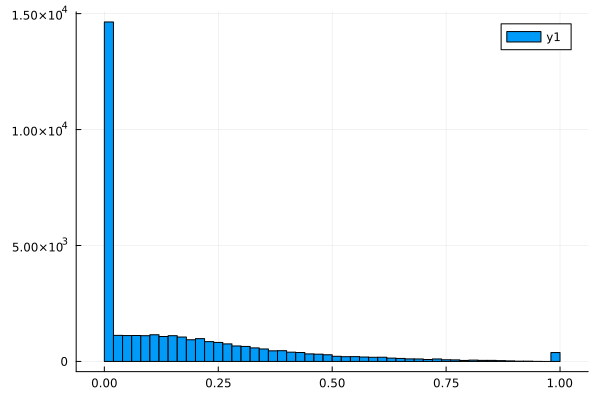

In [67]:
histogram(hsqs_from_null_nc)

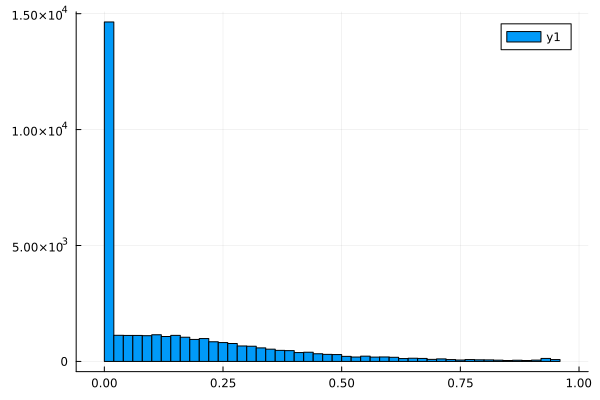

In [68]:
histogram(hsqs_from_null_std)

## Test scan with liteqtl:

In [73]:
test_perms_1000

1001×7321 Matrix{Float64}:
 0.0219153   0.0219153   0.0219153   …  0.285893    0.229505    0.229505
 0.577071    0.577071    0.577071       0.26743     0.299685    0.299685
 0.416471    0.416471    0.416471       0.191429    0.192221    0.192221
 0.109243    0.109243    0.109243       0.0361814   0.0995112   0.0995112
 0.140566    0.140566    0.140566       0.0742643   0.0161596   0.0161596
 0.149453    0.149453    0.149453    …  0.0198113   0.0205044   0.0205044
 0.00739397  0.00739397  0.00739397     0.00137924  0.0134889   0.0134889
 0.00150617  0.00150617  0.00150617     0.0762705   0.199658    0.199658
 0.100859    0.100859    0.100859       0.0271475   0.0160348   0.0160348
 0.0018406   0.0018406   0.0018406      0.321976    0.393946    0.393946
 0.00113183  0.00113183  0.00113183  …  1.07409     1.29878     1.29878
 0.160275    0.160275    0.160275       0.37832     0.159057    0.159057
 0.157727    0.157727    0.157727       1.61675e-5  0.0136732   0.0136732
 ⋮                 

In [74]:
t1

1001×7321 Matrix{Float64}:
 0.0199558   0.0199558   0.0199558   …  0.310909    0.221124   0.221124
 0.143939    0.143939    0.143939       0.230489    0.152399   0.152399
 0.0307661   0.0307661   0.0307661      0.130346    0.172232   0.172232
 0.00241681  0.00241681  0.00241681     0.0849099   0.223659   0.223659
 0.746577    0.746577    0.746577       0.0446912   0.0125163  0.0125163
 0.0155682   0.0155682   0.0155682   …  0.0957436   0.0791677  0.0791677
 0.407148    0.407148    0.407148       0.20206     0.596031   0.596031
 0.00032049  0.00032049  0.00032049     0.0666728   0.233991   0.233991
 0.0119965   0.0119965   0.0119965      0.00592422  0.0119439  0.0119439
 0.784951    0.784951    0.784951       0.203104    0.336345   0.336345
 2.911e-5    2.911e-5    2.911e-5    …  0.42277     0.26349    0.26349
 0.0331747   0.0331747   0.0331747      0.391905    0.415453   0.415453
 0.0669042   0.0669042   0.0669042      0.267569    0.298876   0.298876
 ⋮                                 

In [76]:
using LoopVectorization

In [77]:
include("../src/scan_LiteQTL.jl")

bulkscan (generic function with 1 method)

In [ ]:
t1 = scan_perms(c_pheno_y, c_geno, kinship_Gc; prior_a = 1.0, prior_b = 0.1, method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);

In [82]:
BLAS.get_num_threads()

4

In [79]:
Threads.nthreads()

4

In [81]:
BLAS.set_num_threads(Threads.nthreads())

In [199]:
include("../src/parallel_helpers.jl")

transform_permute (generic function with 1 method)

In [198]:
include("../src/scan.jl")

scan_perms_distributed (generic function with 1 method)

In [206]:
A = [1 2; 3 4]

2×2 Matrix{Int64}:
 1  2
 3  4

In [208]:
mapslices(x -> norm(x), A, dims = 1)

1×2 Matrix{Float64}:
 3.16228  4.47214

In [200]:
@time test_perms_1000 = scan_perms(pheno_y, geno, kinship_Gc; prior_a = 1.0, prior_b = 0.1, method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);

  7.595108 seconds (103.87 k allocations: 17.629 GiB, 41.85% gc time)


In [216]:
function scan_perms_lite(y::Array{Float64,2}, g::Array{Float64,2}, K::Array{Float64,2};
              prior_a::Float64 = 0.0, prior_b::Float64 = 0.0, addIntercept::Bool = true, method::String = "qr",
              nperms::Int64 = 1024, rndseed::Int64 = 0, 
              reml::Bool = false, original::Bool = true)
    
    
    # check the number of traits as this function only works for permutation testing of univariate trait
    if(size(y, 2) != 1)
        error("Can only handle one trait.")
    end

    sy = colStandardize(y);
    sg = colStandardize(g);
    
    
    # n - the sample size
    # p - the number of markers
    (n, p) = size(g)

    ## Note: estimate once the variance components from the null model and use for all marker scans
    # fit lmm
    (y0, X0, lambda0) = transform_rotation(sy, sg, K; addIntercept = addIntercept); # rotation of data
    (r0, X00, sigma2) = transform_reweight(y0, X0, lambda0; prior_a = prior_a, prior_b = prior_b, reml = reml, method = method); # reweighting and taking residuals

    # If no permutation testing is required, move forward to process the single original vector
    if nperms == 0

        if original == false
            throw(error("If no permutation testing is required, input value of `original` has to be `true`."));
        end
    
        r0perm = r0;
    else
        r0perm = transform_permute(r0; nperms = nperms, rndseed = rndseed, original = original);
    end
    
    # std_y = std(r0perm, dims = 1) |> vec;
    # std_x = std(X00, dims = 1) |> vec;
    
    norm_y = mapslices(x -> norm(x)/sqrt(n), r0perm, dims = 1) |> vec;

    norm_X = mapslices(x -> norm(x)/sqrt(n), X00, dims = 1) |> vec;

    
    colDivide!(r0perm, norm_y);
    colDivide!(X00, norm_X);
    
    lods = X00' * r0perm
    tR2LOD!(lods, n);
    
    return lods
    
end

scan_perms_lite (generic function with 1 method)

In [217]:
@time test_perms_1000_lite = scan_perms_lite(pheno_y, geno, kinship_Gc; prior_a = 1.0, prior_b = 0.1, method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);

  0.164229 seconds (137.87 k allocations: 97.484 MiB, 65.06% compilation time)


In [218]:
permutedims(test_perms_1000_lite)

1001×7321 Matrix{Float64}:
 0.0199558   0.0199558   0.0199558   0.0199558   …  0.221124     0.221124
 0.597741    0.597741    0.597741    0.597741       0.231237     0.231237
 0.565781    0.565781    0.565781    0.565781       0.166673     0.166673
 0.130609    0.130609    0.130609    0.130609       0.0984779    0.0984779
 0.235381    0.235381    0.235381    0.235381       0.0246234    0.0246234
 0.161319    0.161319    0.161319    0.161319    …  0.020107     0.020107
 0.00010056  0.00010056  0.00010056  0.00010056     0.030925     0.030925
 0.00635308  0.00635308  0.00635308  0.00635308     0.243614     0.243614
 0.0653776   0.0653776   0.0653776   0.0653776      0.0180202    0.0180202
 0.0060824   0.0060824   0.0060824   0.0060824      0.510765     0.510765
 0.0162535   0.0162535   0.0162535   0.0162535   …  1.20044      1.20044
 0.189371    0.189371    0.189371    0.189371       0.105339     0.105339
 0.0499736   0.0499736   0.0499736   0.0499736      0.0181551    0.0181551
 ⋮      

In [219]:
test_perms_1000

1001×7321 Matrix{Float64}:
 0.0199558   0.0199558   0.0199558   0.0199558   …  0.221124     0.221124
 0.597741    0.597741    0.597741    0.597741       0.231237     0.231237
 0.565781    0.565781    0.565781    0.565781       0.166673     0.166673
 0.130609    0.130609    0.130609    0.130609       0.0984779    0.0984779
 0.235381    0.235381    0.235381    0.235381       0.0246234    0.0246234
 0.161319    0.161319    0.161319    0.161319    …  0.020107     0.020107
 0.00010056  0.00010056  0.00010056  0.00010056     0.030925     0.030925
 0.00635308  0.00635308  0.00635308  0.00635308     0.243614     0.243614
 0.0653776   0.0653776   0.0653776   0.0653776      0.0180202    0.0180202
 0.0060824   0.0060824   0.0060824   0.0060824      0.510765     0.510765
 0.0162535   0.0162535   0.0162535   0.0162535   …  1.20044      1.20044
 0.189371    0.189371    0.189371    0.189371       0.105339     0.105339
 0.0499736   0.0499736   0.0499736   0.0499736      0.0181551    0.0181551
 ⋮      

In [220]:
maxSqDiff(permutedims(test_perms_1000_lite), test_perms_1000)

1.5272347125078789e-27

In [221]:
findmax(abs.(permutedims(test_perms_1000_lite) .- test_perms_1000))

(3.907985046680551e-14, CartesianIndex(1, 6070))

In [222]:
sumSqDiff(permutedims(test_perms_1000_lite), test_perms_1000)

1.2051053440039313e-22

In [223]:
test_perms_1000[57, 555]

4.473671958456262